## FIGURE: identification results
We are going to use this notebook to create a figure about different cases of identification.
Columns will be: some afm images, the ground truth, the prediction in green or red if it is correct or incorrect and the tanimoto of the prediction. 
We can make two figures, one with several cases of success and other with several of mistakes. 

The mistakes will be: a molecule with switched radicals, a molecule where structure repeats and a molecule where the prediction simply fails. 

In [1]:
def load_exp_img_stack(path, dimensions=[224,224], zoom=1):
    '''Obtains stack of experimental images from folder path and preprocess 
        it so we can directly feed it to our CNN

        INPUT: path of the folder containing the AFM images of the molecule

        OUTPUT: list of PIL images'''
    path_list = sorted(glob.glob(os.path.join(path,'*')))
    im_list = list()
    for im_path in path_list:
        
        im_list.append(Image.open(im_path).resize(dimensions, resample=Image.Resampling.BILINEAR).convert('L'))
        
    # Default parameters
        degrees = 0
        h_shift = 0
        v_shift = 0
        shear = 0

        
    for i in range(len(im_list)):
        im_list[i] = TF.affine(im_list[i], degrees, [h_shift, v_shift], zoom, shear,
                                interpolation=transforms.InterpolationMode.BILINEAR,
                                fill=im_list[i].getpixel((5, 5))
                                )

    to_tensor = transforms.ToTensor()

    tensor_stack = [to_tensor(im) for im in im_list.copy()]
    tensor_stack = torch.cat(tensor_stack)

    #normalize = transforms.Normalize(
    #    mean=[0.1321, 0.1487, 0.1689, 0.1983, 0.2229, 0.2591, 0.3430, 0.4580, 0.5787, 0.6887],
    #    std=[0.0853, 0.0853, 0.0883, 0.0942, 0.0969, 0.1066, 0.1419, 0.1840, 0.2144, 0.2215]) #this is for K-1



    normalize = transforms.Normalize(
        mean=[0.2855, 0.3973, 0.4424, 0.4134, 0.6759, 1.0664, 0.9904, 0.7708, 0.5748, 0.4055],
        std=[1.1341, 1.2528, 1.3125, 1.3561, 1.5844, 1.7763, 1.5447, 1.2683, 1.0588, 0.9308]) # for all K folders
    
    tensor_stack = normalize(tensor_stack)

    return tensor_stack

def load_jmol_image(cid, dimension=[224,224], zoom=1):
    if USER=='manuel':
        path = f'/home/{USER}/QUAM-AFM/QUAM/JMOL_IMAGES/{cid}/{cid}.png' ##Mustang
    else:
        path = f'/scratch/dataset/quam/JMOL_IMAGES/{cid}/{cid}.png' ##Rocinante
    jmol_image = Image.open(path)
     # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    
    # Apply zoom by cropping
    width, height = jmol_image.size
    left = width * ((1 - zoom) / 2)
    top = height * ((1 - zoom) / 2)
    right = width * ((1 + zoom) / 2)
    bottom = height * ((1 + zoom) / 2)
    jmol_image = jmol_image.crop((left, top, right, bottom))
    
    # Resize image to desired dimensions
    jmol_image = jmol_image.resize(dimension, resample=Image.Resampling.BILINEAR)
    
    # Convert to numpy array
    jmol_image_array = np.array(jmol_image)
    
    return jmol_image_array

def _extract_cid(path):
    return int(path.split('_')[-3])

def run_prediction_extra(molec_path, dimension=[224,224], zoom=1, verbose=False):
    img_stack = load_img_stack(molec_path)
    true_CID = _extract_cid(molec_path)

    fp_pred = predict_fp(model, molec_path, device,  thres = 0.5)

    output_df = fp_screening_function(fp_pred, test_df, top_k = 5, int_type=np.int8)


    first_CID = _extract_cid(output_df.iloc[0]['path'])
    second_CID = _extract_cid(output_df.iloc[1]['path'])
    tanimoto_first = output_df.iloc[0]['tanimoto']
    tanimoto_second = output_df.iloc[1]['tanimoto']
    
    gt_jmol = load_jmol_image(true_CID, dimension=dimension, zoom=zoom)
    first_jmol = load_jmol_image(first_CID, dimension=dimension, zoom=zoom)
    second_jmol = load_jmol_image(second_CID, dimension=dimension, zoom=zoom)

    
    if verbose:
        print('Total number of fingerprints', np.sum(fp_pred))
        print('Is the correct CID in the top k candidates?',  true_CID in list(output_df['CID']))
        print('Is the correct CID the first candidate?',  true_CID == output_df['CID'].iloc[0])
        print(f'top candidate: {first_CID} tanimoto: {tanimoto_first}')
        print(f'second candidate: {second_CID} tanimoto: {tanimoto_second}')
        print('########################')
        print(output_df.iloc[:5]['CID'])
        print('########################')
        
    
    return img_stack[1], img_stack[3], img_stack[5], gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second


def plot_images(img_1, img_3, img_5, gt_jmol, pred_jmol, true_CID, pred_CID, tanimoto):
    fig, ax = plt.subplots(1, 5, figsize=(20, 4))

    ax[0].imshow(img_1, cmap='gray')
    ax[0].axis('off')
    ax[1].imshow(img_3, cmap='gray')
    ax[1].axis('off')
    ax[2].imshow(img_5, cmap='gray')
    ax[2].axis('off')
    ax[3].imshow(gt_jmol)
    ax[3].axis('off')
    ax[4].imshow(pred_jmol)


    if true_CID == pred_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), pred_jmol.shape[1], pred_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    ax[4].add_patch(rect)
    ax[4].set_xticks([])
    ax[4].set_yticks([])
    ax[4].set_xlabel(f'Tanimoto: {tanimoto:.2f}', fontsize=20)

    plt.tight_layout()
    plt.show()

In [2]:
# IMPORTS
# torch packages
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, efficientnet_b0, EfficientNet_B0_Weights
import torchvision.transforms.functional as TF

from torchmetrics import MetricCollection
from torchmetrics.classification import MultilabelRecall, MultilabelPrecision, MultilabelF1Score

import torch.nn.functional as F
from torch.utils.data import Dataset

print('PyTorch version:', torch.__version__)

# additional packages
from PIL import Image
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import rdkit.Chem.AllChem as AllChem
import random
import argparse
import os
import time
import glob
from tqdm import tqdm
import scipy
import seaborn as sns
import pickle
#import rdkit.Chem.AllChem as AllChem
import rdkit.Chem as Chem
import sys
USER = os.getenv('USER')
sys.path.append('../../.')


# custom functions
from utils.all_utils import train_test_split, compute_pos_weights, save_config, train_for_epoch, validate, \
                            balance_beta_pos_weights, tanimoto_torch, validate_tanimoto

from utils.models import ResNet3D, resnet_10_chan, effnet_10_chan, eff_net_bias_warmer, resnet_bias_warmer 

from utils.dataloader import QUAM_with_noise, parse_val_ks

from utils.screening import fp_screening_function, load_img_stack, predict_fp, tanimoto_numpy



print('Packages loaded')


class configuration:
    def __init__(self):
        # EXPERIMENT PARAMETERS
        self.experiment_name = 'exp_imgs'
        self.n_fp = 1024  # number of fingerprints
        self.output_size = 9
        self.ratio = 0.95  # train/test ratio
        self.seed = 42

        # TRAINING PARAMETERS

        self.lr = 0.001  # learning rate
        self.dropout = 0.5 # Dropout2d probability
        # self.momentum = 0.9  # momentum of SGD optimizer
        self.weight_decay = 0  # L2 regularization constant
        self.batch_size = 50  # Training batch size
        self.test_batch_size = 50  # Test batch size
        self.epochs = 150  # Number of epochs
        self.bias_warmer = True # setting appropiate bias
        self.pos_weight_balancer = True #for bigger fingerprints, it helps balance precision and recall
        self.pos_weight_beta = 10
        # DATA AUGMENTATION PARAMETERS

        # Rotation
        self.rot_prob = 0.5  # prob of rotation in data augmentation
        self.max_deg = 180  # maximum degrees of rotation in data augmentation

        # Zoom
        self.zoom_prob = 0.3  # prob of applying zoom
        self.max_zoom = 0.3  # maximum zooming in/out

        # Translation
        self.shift_prob = 0.3  # probability of vertical or/and horizontal translation
        self.max_shift = 20  # translation

        # Shear
        self.shear_prob = 0.3  # probability of shearing
        self.max_shear = 10  # maximum shearing angle

## Create arguments object
args = configuration()
# Print experiment name
print('Experiment name:', args.experiment_name)


# make sure to enable GPU acceleration!
print(f'available devices: {torch.cuda.device_count()}')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#torch.cuda.device(0)
#device = torch.device('cpu')
#print(device, torch.cuda.get_device_name(0))

# Set random seed for reproducibility
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/mgonzalez/.conda/envs/pytorch/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


PyTorch version: 2.2.1+cu121
Packages loaded
Experiment name: exp_imgs
available devices: 0


In [3]:
# FOR CPU
# model and metrics initialization

# model = ResNet3D(output_size=args.n_fp)
model = effnet_10_chan(output_size=args.n_fp, dropout=args.dropout)


models_path = '../../models/300k_1024_all_ks_dropout_0_5/models'
checkpoint = torch.load(os.path.join(models_path, 'checkpoint_5_virtual_epoch_7.pth'), map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(10, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout2d(p=0.5, inplace=False)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivation(
            (0): Conv2d(32, 16, kernel_siz

In [4]:
# Load data
data_path = '../../data/dataset/285k_train_15k_fp_and_atom_counts_w_H.gz'
dataset_df = pd.read_pickle(data_path)

test_df = dataset_df[dataset_df['split'] == 'test']
test_df = parse_val_ks(test_df)




### Fig 3

/scratch/dataset/quam/K-6/Conformer3D_CID_143932_K040_Amp140
Total number of fingerprints 19
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 143932 tanimoto: 0.8947368421052632
second candidate: 6857588 tanimoto: 0.75
########################
6438        143932
219765     6857588
215021    59787234
1002      59787233
232117    86104371
Name: CID, dtype: int64
########################
143932 143932 6857588
/scratch/dataset/quam/K-14/Conformer3D_CID_636081_K080_Amp060
Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 636081 tanimoto: 0.7368421052631579
second candidate: 85721330 tanimoto: 0.6956521739130435
########################
37905        636081
231892     85721330
194185     13766977
61524     124003402
174000     11995190
Name: CID, dtype: int64
########################
636081 636081 85721330
/scratch/dataset/quam/K-24/Conformer3D

/tmp/ipykernel_207695/1401504788.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('pah_identification_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_207695/1401504788.py:67: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('pah_identification_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)


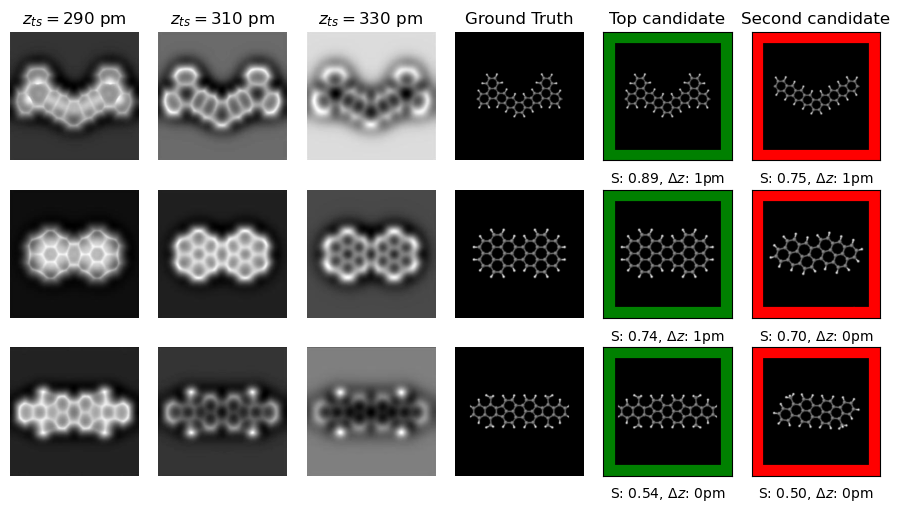

In [11]:
# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=3
molec_paths = [
        '/scratch/dataset/quam/K-6/Conformer3D_CID_143932_K040_Amp140',
        '/scratch/dataset/quam/K-14/Conformer3D_CID_636081_K080_Amp060',
        '/scratch/dataset/quam/K-24/Conformer3D_CID_59721948_K100_Amp140']

titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.7))  # Adjust figsize according to your needs
for i in range(n_results):
    MOLECULE_INDEX = i*40000 + 500
    molec_path = molec_paths[i]
    print(molec_path)
    if i ==0:
        img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=1.5, verbose=True)
    elif i ==2:
        img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=1.3, verbose=True)
    else:
        img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=1.2, verbose=True)
    print(true_CID, first_CID, second_CID)
    corrugation_first = test_df[test_df['CID']==first_CID]['corrugation'].values[0]
    corrugation_second = test_df[test_df['CID']==second_CID]['corrugation'].values[0]
    ax[i,0].imshow(img_1, cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(img_3, cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(img_5, cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(first_jmol)
    ax[i,5].imshow(second_jmol)


    if true_CID == first_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
   
    if true_CID == second_CID:
        color = 'green'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')     
    

    ax[i,4].add_patch(rect)
    ax[i,5].add_patch(rect_2)
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto_first:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column
    if i == 0:
        for j in range(len(titles)):
            ax[i,j].set_title(titles[j])

#######################################

plt.tight_layout()
plt.savefig('pah_identification_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()

### Fig 4

/scratch/dataset/quam/K-1/Conformer3D_CID_2748722_K040_Amp040
Total number of fingerprints 15
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 2748722 tanimoto: 0.8125
second candidate: 270010 tanimoto: 0.6363636363636364
########################
1131       2748722
116823      270010
31895     21856870
78873     54058316
231737      852658
Name: CID, dtype: int64
########################
2748722 2748722 270010
/scratch/dataset/quam/K-4/Conformer3D_CID_63616469_K040_Amp100
Total number of fingerprints 39
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 63616469 tanimoto: 0.9743589743589743
second candidate: 63616316 tanimoto: 0.6170212765957447
########################
83816     63616469
83814     63616316
217800    64446716
83830     63615331
454478    64395594
Name: CID, dtype: int64
########################
63616469 63616469 63616316
/scratch/dataset/quam/K-7/Confor

/tmp/ipykernel_207695/1969367477.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('vs_good_pred_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_207695/1969367477.py:57: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('vs_good_pred_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)


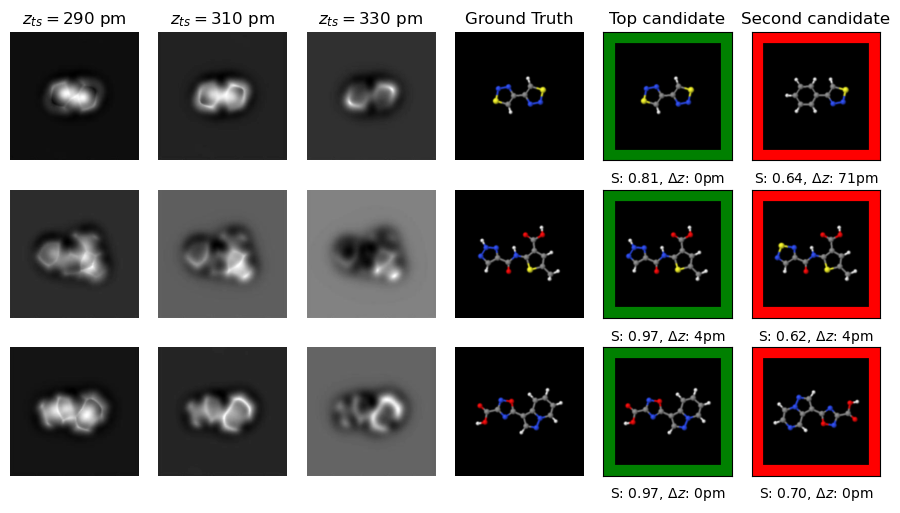

In [12]:
# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=3
titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.7))  # Adjust figsize according to your needs
for i in range(n_results):
    MOLECULE_INDEX = i*40000 + 500
    molec_path = test_df.iloc[MOLECULE_INDEX]['path']
    print(molec_path)
    
    img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=0.8, verbose=True)
    print(true_CID, first_CID, second_CID)
    corrugation_first = test_df[test_df['CID']==first_CID]['corrugation'].values[0]
    corrugation_second = test_df[test_df['CID']==second_CID]['corrugation'].values[0]
    ax[i,0].imshow(img_1, cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(img_3, cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(img_5, cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(first_jmol)
    ax[i,5].imshow(second_jmol)


    if true_CID == first_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
   
    if true_CID == second_CID:
        color = 'green'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')     
    

    ax[i,4].add_patch(rect)
    ax[i,5].add_patch(rect_2)
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto_first:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
    # Setting titles for each column
    if i == 0:
        for j in range(len(titles)):
            ax[i,j].set_title(titles[j])

#######################################

plt.tight_layout()
plt.savefig('vs_good_pred_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()


### Fig 5

/scratch/dataset/quam/K-14/Conformer3D_CID_58899415_K080_Amp060
Total number of fingerprints 25
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 58899415 tanimoto: 0.6206896551724138
second candidate: 54439774 tanimoto: 0.4117647058823529
########################
27202      58899415
26455      54439774
532712    129149092
141855     12858639
6952        6428541
Name: CID, dtype: int64
########################
58899415 58899415 54439774
/scratch/dataset/quam/K-24/Conformer3D_CID_59332995_K100_Amp140
Total number of fingerprints 20
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 59332995 tanimoto: 0.782608695652174
second candidate: 131010917 tanimoto: 0.5833333333333334
########################
577689     59332995
511749    131010917
337356     60145703
575744    131055902
258287    119012787
Name: CID, dtype: int64
########################
59332995 59332995 131010917

/tmp/ipykernel_207695/1121913219.py:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('identification_3_cases_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_207695/1121913219.py:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('identification_3_cases_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)


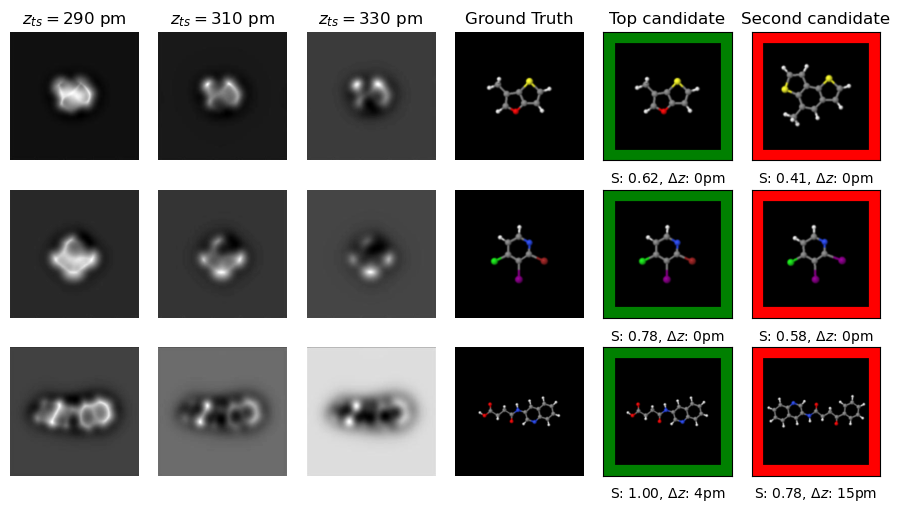

In [13]:
# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=3
molec_paths = ['/scratch/dataset/quam/K-14/Conformer3D_CID_58899415_K080_Amp060',  
        '/scratch/dataset/quam/K-24/Conformer3D_CID_59332995_K100_Amp140',
        '/scratch/dataset/quam/K-18/Conformer3D_CID_861757_K080_Amp140']
zoom_list = [0.7, 0.7, 1.1]


titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.7))  # Adjust figsize according to your needs
for i in range(n_results):
    MOLECULE_INDEX = i*40000 + 500
    molec_path = molec_paths[i]
    print(molec_path)
    zoom = zoom_list[i]
    img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=zoom, verbose=True)
    print(true_CID, first_CID, second_CID)
    corrugation_first = test_df[test_df['CID']==first_CID]['corrugation'].values[0]
    corrugation_second = test_df[test_df['CID']==second_CID]['corrugation'].values[0]
    ax[i,0].imshow(img_1, cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(img_3, cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(img_5, cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(first_jmol)
    ax[i,5].imshow(second_jmol)


    if true_CID == first_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
   
    if true_CID == second_CID:
        color = 'green'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')     
    

    ax[i,4].add_patch(rect)
    ax[i,5].add_patch(rect_2)
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto_first:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column
    if i == 0:
        for j in range(len(titles)):
            ax[i,j].set_title(titles[j])

#######################################

plt.tight_layout()
plt.savefig('identification_3_cases_second_candidates_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()

### Fig 6

/scratch/dataset/quam/K-2/Conformer3D_CID_135178930_K040_Amp060
Total number of fingerprints 40
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 135178930 tanimoto: 0.9512195121951219
second candidate: 135178929 tanimoto: 0.9512195121951219
########################
18066     135178930
18065     135178929
209720       470402
209791       473475
185889    135167504
Name: CID, dtype: int64
########################
135178930 135178930 135178929
/scratch/dataset/quam/K-7/Conformer3D_CID_123044_K060_Amp040
Total number of fingerprints 11
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? False
top candidate: 5460712 tanimoto: 1.0
second candidate: 7080 tanimoto: 1.0
########################
78524      5460712
146499        7080
20518      6857587
300         123044
13793     12657598
Name: CID, dtype: int64
########################
123044 5460712 7080
/scratch/dataset/quam/K-12/Conformer3D_CID_1

/tmp/ipykernel_207695/673882622.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('vs_bad_pred_4_cases_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_207695/673882622.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('vs_bad_pred_4_cases_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)


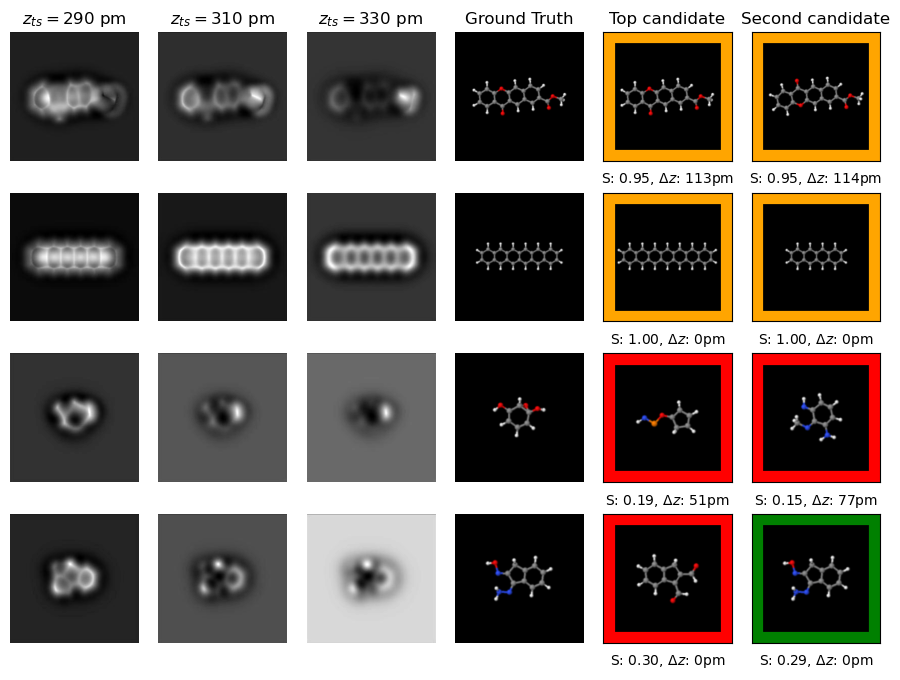

In [14]:
# Final figure: Mirar la corrugación de la molécula y ver el segundo candidato.
n_results=4
titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.7))  # Adjust figsize according to your needs

molec_path_array=[ '/scratch/dataset/quam/K-2/Conformer3D_CID_135178930_K040_Amp060',
                  '/scratch/dataset/quam/K-7/Conformer3D_CID_123044_K060_Amp040', 
                  '/scratch/dataset/quam/K-12/Conformer3D_CID_129866873_K060_Amp140',
                  '/scratch/dataset/quam/K-24/Conformer3D_CID_137221883_K100_Amp140'
                 ]
for i in range(n_results):
    molec_path = molec_path_array[i]
    if i==0:
        zoom=1
    elif i==1:
        zoom = 1.2
    else:
        zoom=0.8    
    
    print(molec_path)
    
    img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=zoom, verbose=True)
    print(true_CID, first_CID, second_CID)
    corrugation_first = test_df[test_df['CID']==first_CID]['corrugation'].values[0]
    corrugation_second = test_df[test_df['CID']==second_CID]['corrugation'].values[0]
    ax[i,0].imshow(img_1, cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(img_3, cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(img_5, cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(first_jmol)
    ax[i,5].imshow(second_jmol)


    if true_CID == first_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
   
    if true_CID == second_CID:
        color = 'green'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')     
    
    if tanimoto_first == tanimoto_second:
        color = 'orange'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')

    ax[i,4].add_patch(rect)
    ax[i,5].add_patch(rect_2)
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto_first:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column
    if i == 0:
        for j in range(len(titles)):
            ax[i,j].set_title(titles[j])

#######################################

plt.tight_layout()
plt.savefig('vs_bad_pred_4_cases_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()


### Extra figure ;)

/scratch/dataset/quam/K-14/Conformer3D_CID_636081_K080_Amp060
Total number of fingerprints 18
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 636081 tanimoto: 0.7368421052631579
second candidate: 85721330 tanimoto: 0.6956521739130435
########################
37905        636081
231892     85721330
194185     13766977
61524     124003402
174000     11995190
Name: CID, dtype: int64
########################
636081 636081 85721330
/scratch/dataset/quam/K-14/Conformer3D_CID_58899415_K080_Amp060
Total number of fingerprints 25
Is the correct CID in the top k candidates? True
Is the correct CID the first candidate? True
top candidate: 58899415 tanimoto: 0.6206896551724138
second candidate: 54439774 tanimoto: 0.4117647058823529
########################
27202      58899415
26455      54439774
532712    129149092
141855     12858639
6952        6428541
Name: CID, dtype: int64
########################
58899415 58899415 54439774
/scratch

/tmp/ipykernel_207695/2032777318.py:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "quality" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('identification_4_cases_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
/tmp/ipykernel_207695/2032777318.py:64: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('identification_4_cases_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)


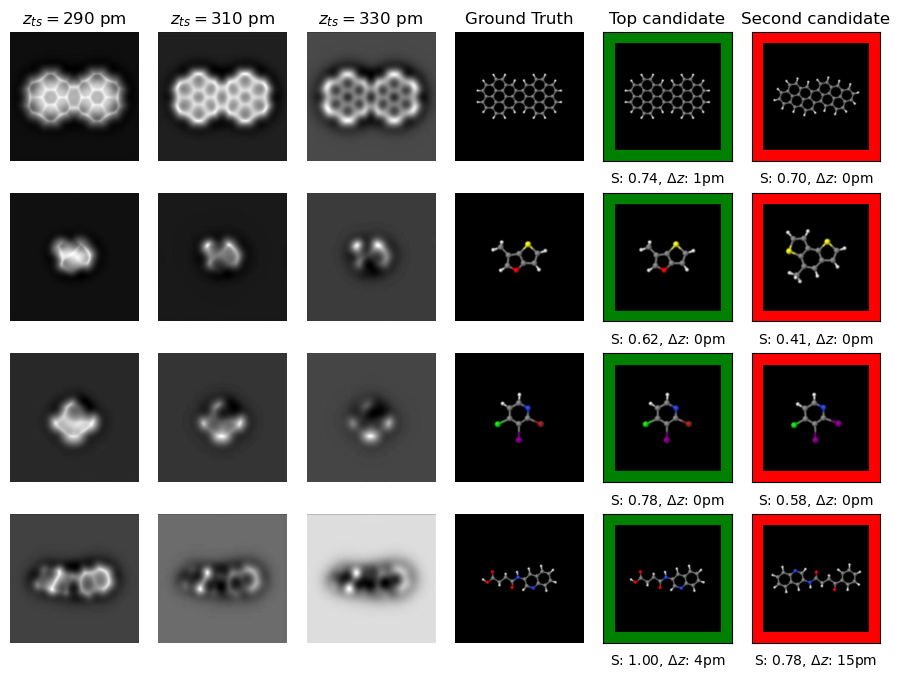

In [15]:
condition = (dataset_df['C'] > 40) & (dataset_df['H'] > 10) & (dataset_df[['Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']].sum(axis=1) == 0)
selected_rows = dataset_df[condition]
zoom_list = [1.3, 0.8, 0.8, 1.2]
n_results=4
paths = ['/scratch/dataset/quam/K-14/Conformer3D_CID_636081_K080_Amp060', 
         '/scratch/dataset/quam/K-14/Conformer3D_CID_58899415_K080_Amp060', 
        '/scratch/dataset/quam/K-24/Conformer3D_CID_59332995_K100_Amp140',
        '/scratch/dataset/quam/K-18/Conformer3D_CID_861757_K080_Amp140']

titles = ['$z_{ts}=290$ pm', '$z_{ts}=310$ pm', '$z_{ts}=330$ pm', 'Ground Truth', 'Top candidate', 'Second candidate']
fig, ax = plt.subplots(n_results, 6, figsize=(9, n_results*1.7))  # Adjust figsize according to your needs
for i, molec_path in enumerate(paths):
    
    print(molec_path)
    zoom = zoom_list[i]
    img_1, img_3, img_5, gt_jmol, first_jmol, second_jmol, true_CID, first_CID, second_CID, tanimoto_first, tanimoto_second = run_prediction_extra(molec_path, dimension=[224,224], zoom=zoom, verbose=True)
    print(true_CID, first_CID, second_CID)
    corrugation_first = test_df[test_df['CID']==first_CID]['corrugation'].values[0]
    corrugation_second = test_df[test_df['CID']==second_CID]['corrugation'].values[0]
    ax[i,0].imshow(img_1, cmap='gray')
    ax[i,0].axis('off')
    ax[i,1].imshow(img_3, cmap='gray')
    ax[i,1].axis('off')
    ax[i,2].imshow(img_5, cmap='gray')
    ax[i,2].axis('off')
    ax[i,3].imshow(gt_jmol)
    ax[i,3].axis('off')
    ax[i,4].imshow(first_jmol)
    ax[i,5].imshow(second_jmol)


    if true_CID == first_CID:
        color = 'green'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
   
    if true_CID == second_CID:
        color = 'green'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')
    else:
        color = 'red'
        rect_2 = patches.Rectangle((0, 0), first_jmol.shape[1], first_jmol.shape[0], linewidth=16, edgecolor=color, facecolor='none')     
    

    ax[i,4].add_patch(rect)
    ax[i,5].add_patch(rect_2)
    ax[i,4].set_xticks([])
    ax[i,4].set_yticks([])
    ax[i,5].set_xticks([])
    ax[i,5].set_yticks([])
    ax[i,4].set_xlabel(f'S: {tanimoto_first:.2f}, $\Delta z$: {int(corrugation_first*100)}pm', fontsize=10)  # Adjust fontsize according to your needs
    ax[i,5].set_xlabel(f'S: {tanimoto_second:.2f}, $\Delta z$: {int(corrugation_second*100)}pm', fontsize=10)  # Adjust fontsize according to your needs

    # Setting titles for each column
    if i == 0:
        for j in range(len(titles)):
            ax[i,j].set_title(titles[j])

#######################################

plt.tight_layout()
plt.savefig('identification_4_cases_v2.pdf', dpi=500, format='pdf', quality=120, optimize=True)
plt.show()